In [3]:
# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 1
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plotting settings
import matplotlib.pyplot as plt
size=35
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

from imageprosessing import crop_mask
def get_highest_contrast_frame(video_sessions):
    max_diff = 0
    max_diff_idx = 0
    for i, vs in enumerate(video_sessions):
        vs.mask_frames_oa790 = crop_mask(vs.mask_frames_oa790, 15)
        diff = vs.masked_frames_oa790[0].max() - vs.masked_frames_oa790[0].min()
        if diff > max_diff:
            max_diff_idx = i
            max_diff = diff
            
    highest_contrast_frame = video_sessions[max_diff_idx].masked_frames_oa790[0]
    highest_contrast_frame = highest_contrast_frame.filled(highest_contrast_frame.mean())
    
    return highest_contrast_frame

Autosaving every 1 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Accessing files

Every file under any folder in ./data is parsed and put into dictionaries that group videos of the same source.
Videos of the same source are considered videos coming from the same Subject, same Session, same OD/OS, same (x, y),
same type (Confocal, OA790, OA850).

The parsing is case insensitive with the following rules:

**unmarked videos**:
must not contain 'mask' or '_marked'

**marked videos**:
Must end with '_marked.\<<file_extension\>>'

**standard deviation images**:
Must end with
'_std.\<<file_extension\>>'

**vessel mask images**: 
Must end with
'_vessel_mask.\<<file_extension\>>'

**channel type**:
must contain one of 'OA790', 'OA850', 'Confocal' (case insensitive)

### Example to using VideoSession objects and the get_video_session() function
(useful for training and training)

In [2]:
from sharedvariables import get_video_sessions
from os.path import basename

video_sessions = get_video_sessions(should_have_marked_cells=True,
                                    should_be_registered=True)
for session in video_sessions:
        assert session.has_marked_video
        assert session.is_registered
        assert session.has_marked_cells
        print('-----------------------')
        print('Video file:', basename(session.video_file))
        print('Does video have a corresponding marked video?:', session.has_marked_video)
        print('Subject number:', session.subject_number)
        print('Session number:', session.session_number)
        print('Marked Video OA790:', basename(session.marked_video_oa790_file))
        print('Std dev image confocal:', basename(session.std_image_confocal_file))
        print('Std dev image OA850:', basename(session.std_image_oa850_file))
        print('Vessel mask OA850:', basename(session.vessel_mask_oa850_file))
        print('Vessel mask confocal:', basename(session.vessel_mask_confocal_file))
        print('Cell position csv files:', *[basename(f) for f in session.cell_position_csv_files], sep='\n')
        print()
        
print('Number of video sessions ', len(video_sessions))

-----------------------
Video file: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped.avi
Does video have a corresponding marked video?: True
Subject number: 25
Session number: 298
Marked Video OA790: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_marked.avi
Std dev image confocal: Subject25_Session298_OD_(-2,0)_1.03x1_1642_Confocal_dewarped1_extract_reg_std.tif
Std dev image OA850: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA850nm_dewarped1_extract_reg_std.tif
Vessel mask OA850: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA850nm_vessel_mask.JPEG
Vessel mask confocal: Subject25_Session298_OD_(-2,0)_1.03x1_1642_Confocal_vessel_mask.jpg
Cell position csv files:
Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_cords.csv

-----------------------
Video file: Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped.avi
Does video have a corresponding marked video?: True
Subject

# Reading frames from videos - (and cell positions for each frame)

You can get access to the frames of the video session.

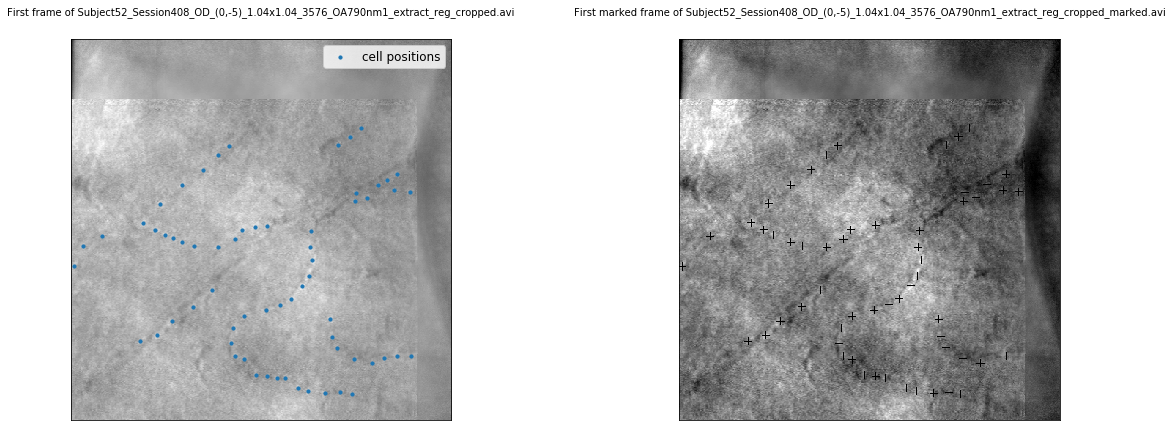

In [27]:
import matplotlib.pyplot as plt
from sharedvariables import get_video_sessions
from plotutils import no_ticks

video_sessions = get_video_sessions(should_have_marked_cells=True,
                                    should_be_registered=True)
_, axes = plt.subplots(1, 2, figsize=(20, 7))
no_ticks(axes)

axes[0].imshow(session.frames_oa790[0], cmap='gray')
axes[0].set_title(f"First frame of {basename(session.video_oa790_file)}", fontsize=10)
axes[0].scatter(session.cell_positions[0][:, 0], session.cell_positions[0][:, 1], label='cell positions', s=10)
axes[0].legend()
    
axes[1].imshow(session.marked_frames_oa790[0], cmap='gray')
axes[1].set_title(f"First marked frame of {basename(session.marked_video_oa790_file)}", fontsize=10)
pass

# How to extract cell and no cell patches

## Using SessionPatchExtractor (Object oriented way) 

### Simple patch extraction

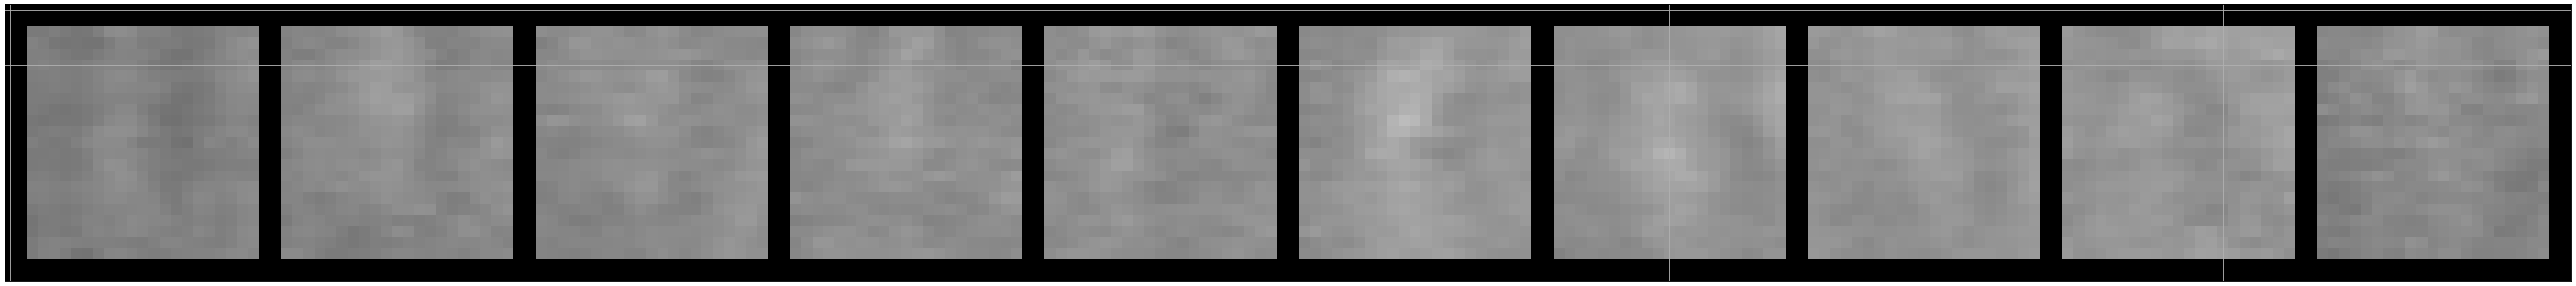

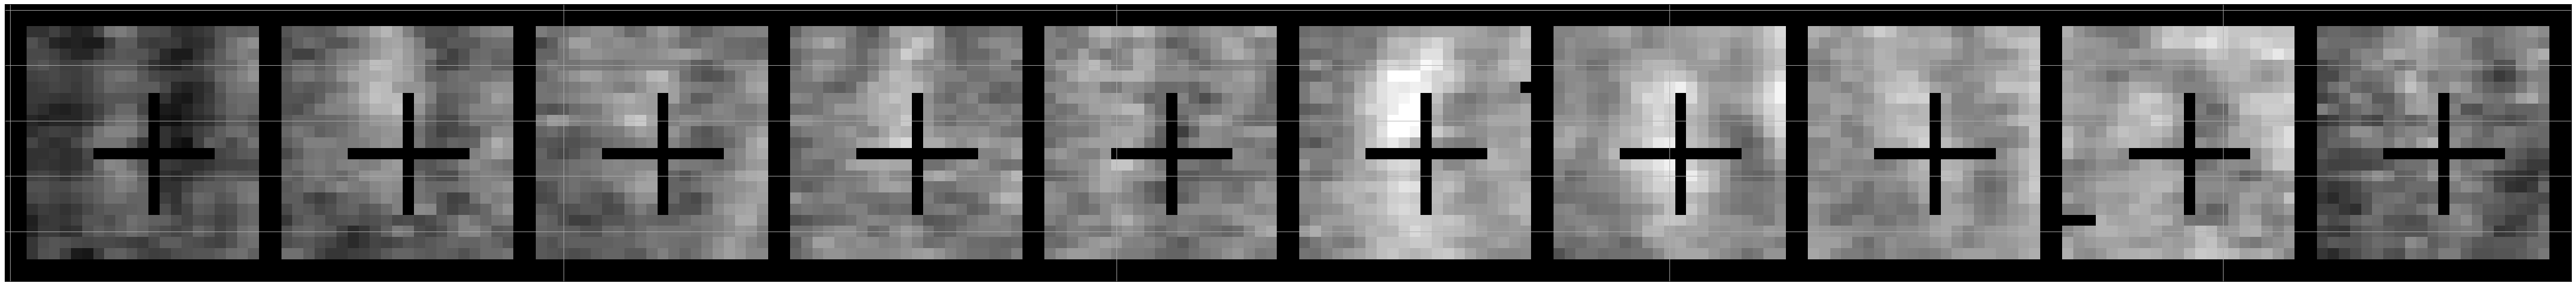

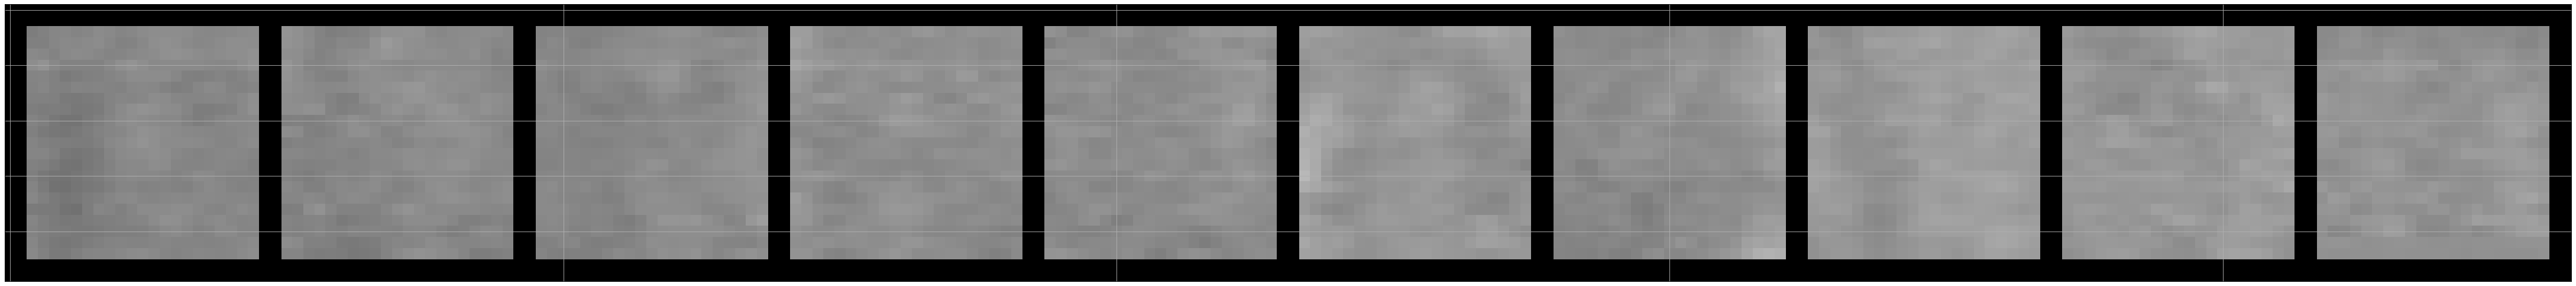

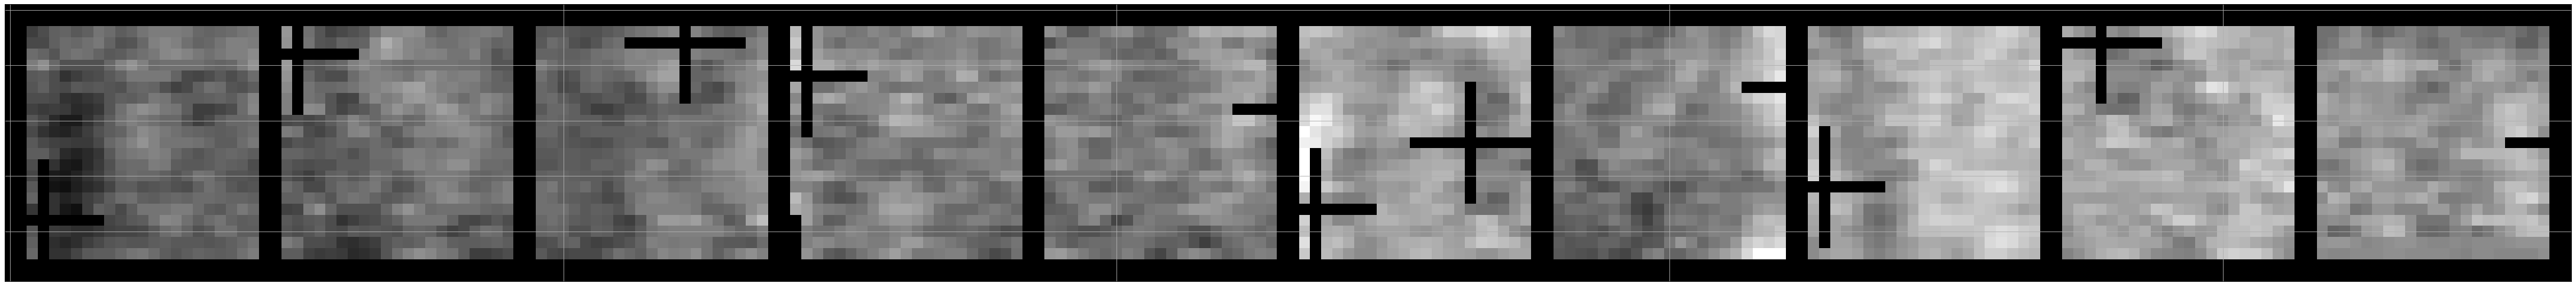

In [29]:
from sharedvariables import get_video_sessions
from patchextraction import SessionPatchExtractor
from plotutils import plot_images_as_grid

video_sessions = get_video_sessions(should_have_marked_cells=True)
vs = video_sessions[0]

patch_extractor = SessionPatchExtractor(vs, patch_size=21)

plot_images_as_grid(patch_extractor.cell_patches_oa790[:10])
plot_images_as_grid(patch_extractor.marked_cell_patches_oa790[:10])

plot_images_as_grid(patch_extractor.non_cell_patches_oa790[:10])
plot_images_as_grid(patch_extractor.marked_non_cell_patches_oa790[:10])

### Temporal patches

Temporal patches shape with temporal width = 4: (843, 21, 21, 9)
Temporal patches shape with temporal width = 5: (736, 21, 21, 11)
Temporal patches shape with temporal width = 6: (627, 21, 21, 13)
As temporal window becomes bigger notice that there are less patches.


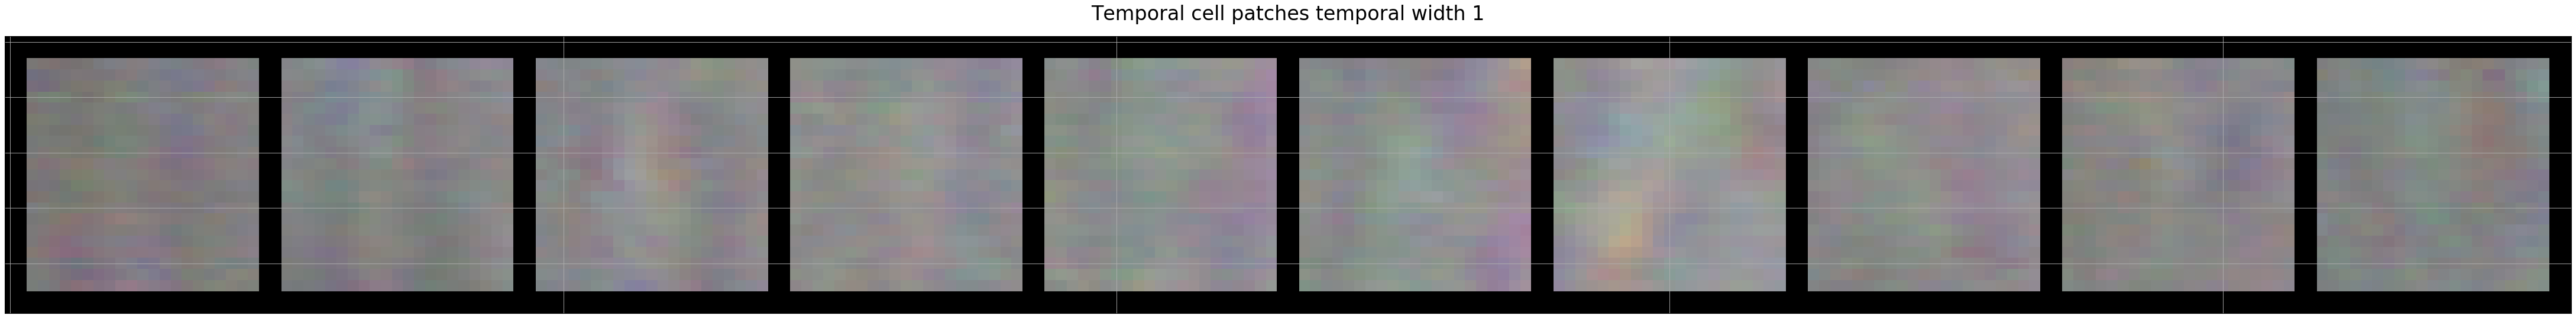

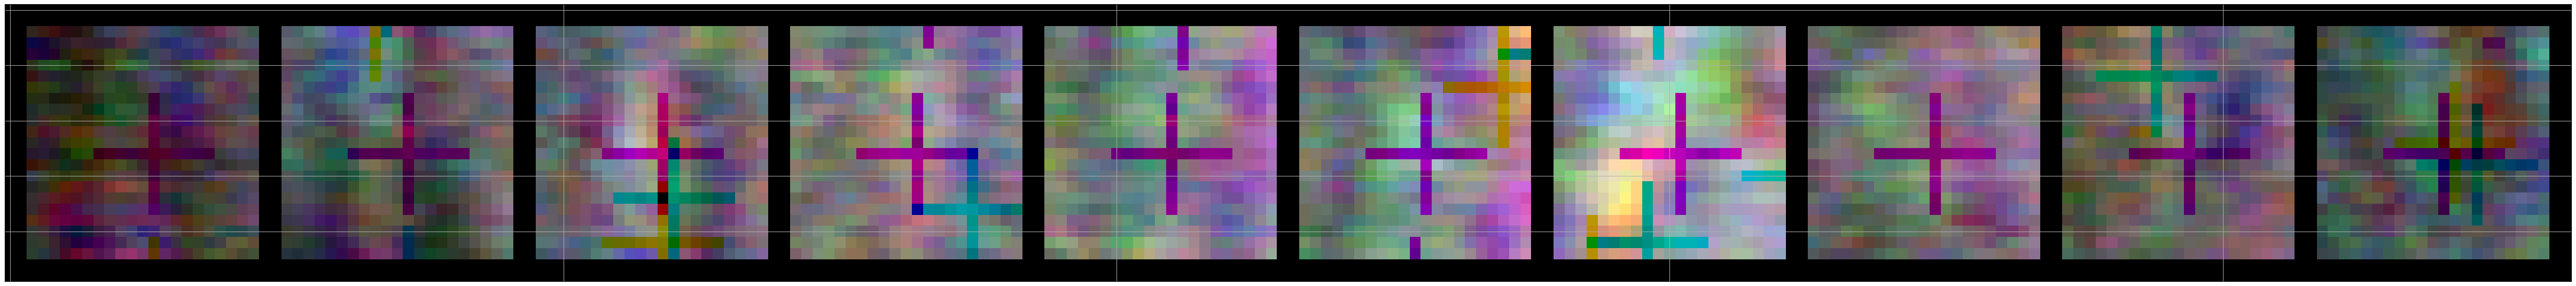

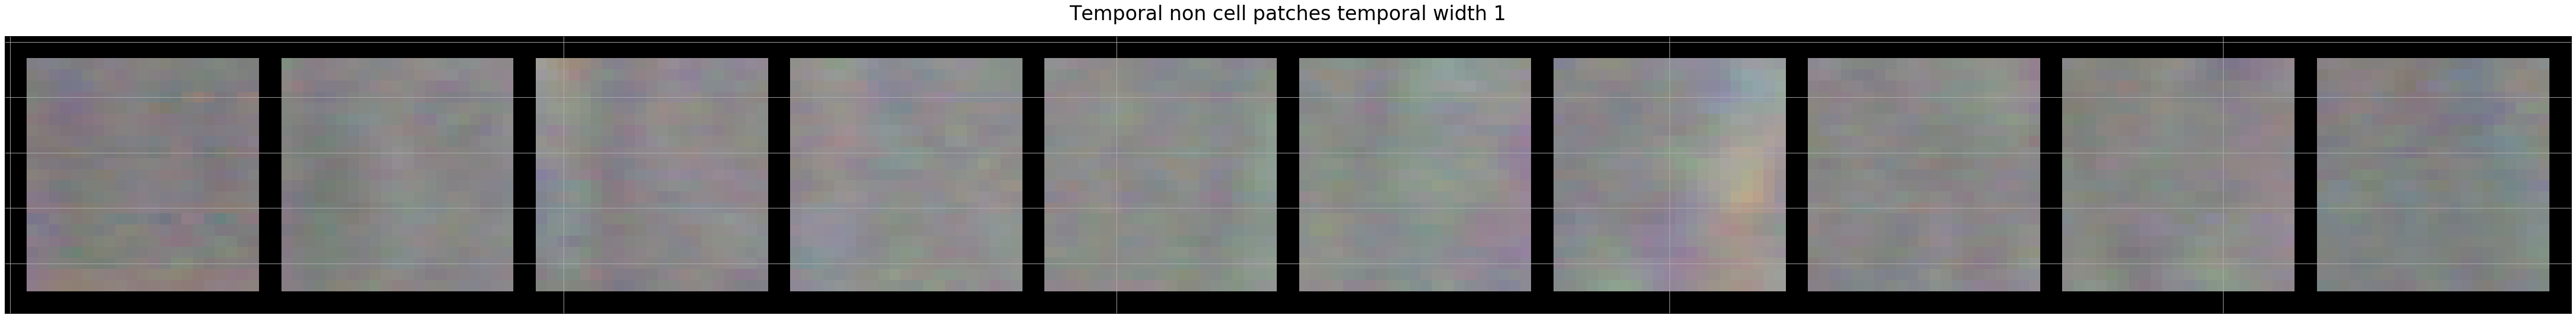

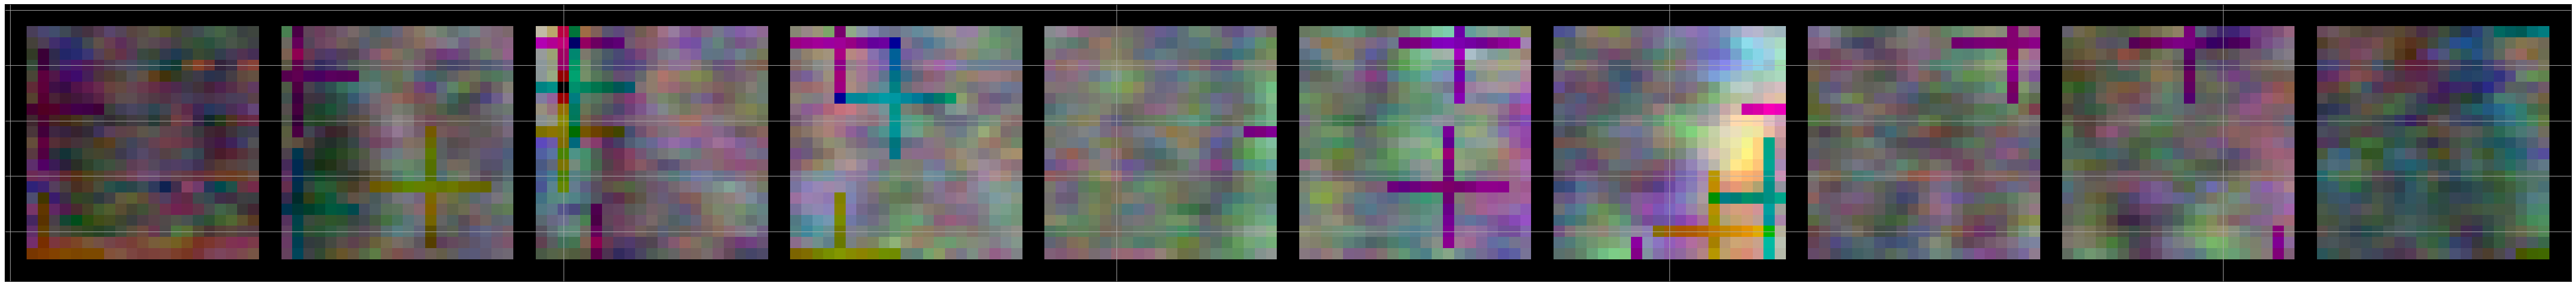

In [39]:
from sharedvariables import get_video_sessions
from patchextraction import SessionPatchExtractor
from plotutils import plot_images_as_grid

video_sessions = get_video_sessions(should_have_marked_cells=True)
vs = video_sessions[0]

patch_extractor = SessionPatchExtractor(vs, patch_size=21, temporal_width=1)

plot_images_as_grid(patch_extractor.temporal_cell_patches_oa790[:10], title='Temporal cell patches temporal width 1')
plot_images_as_grid(patch_extractor.temporal_marked_cell_patches_oa790[:10])

plot_images_as_grid(patch_extractor.temporal_non_cell_patches_oa790[:10], title='Temporal non cell patches temporal width 1')
plot_images_as_grid(patch_extractor.temporal_marked_non_cell_patches_oa790[:10])

# A higher temporal width will give patches with more channells
patch_extractor.temporal_width = 4
print(f'Temporal patches shape with temporal width = 4: {patch_extractor.temporal_cell_patches_oa790.shape}')
patch_extractor.temporal_width = 5
print(f'Temporal patches shape with temporal width = 5: {patch_extractor.temporal_cell_patches_oa790.shape}')
patch_extractor.temporal_width = 6
print(f'Temporal patches shape with temporal width = 6: {patch_extractor.temporal_cell_patches_oa790.shape}')
print(f'As temporal window becomes bigger notice that there are less patches.')

### Mixed channel patches
 
Mixed channel patches give patches with 3 channels, the first channel is confocal video patch, second channel is from the oa780 channel,
third channel is from the oa850 channel.

The confocal video and the oa790 channel have the capillaries at the same position. The oa850 video has a vertical displacement, the video is registered before extracting the patches.

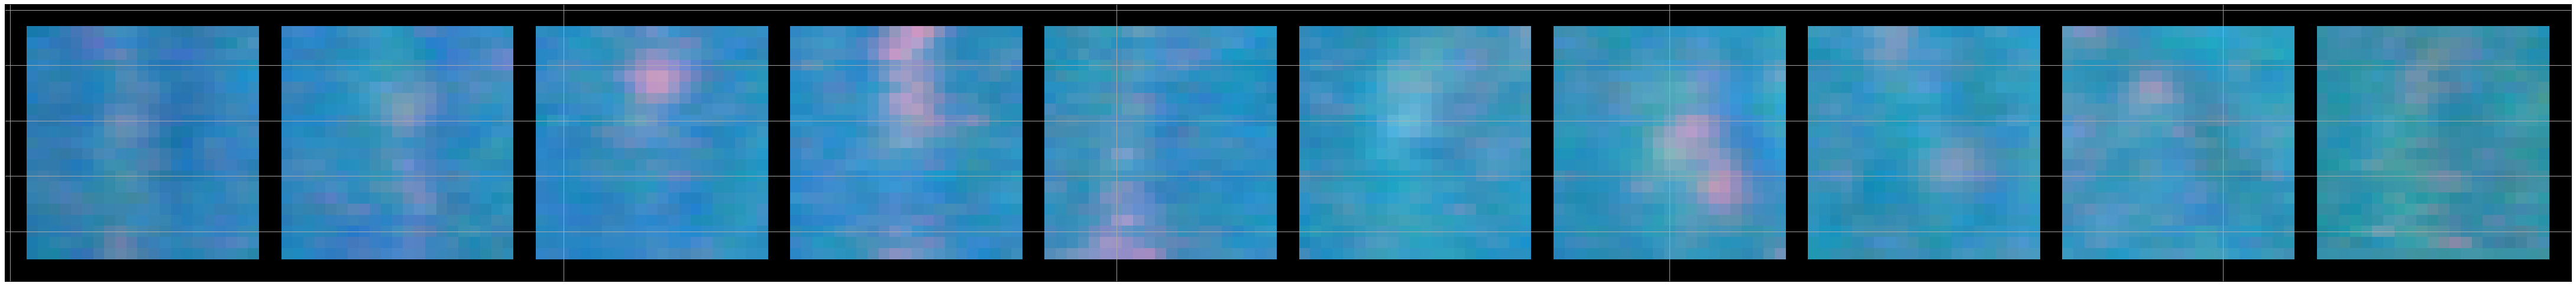

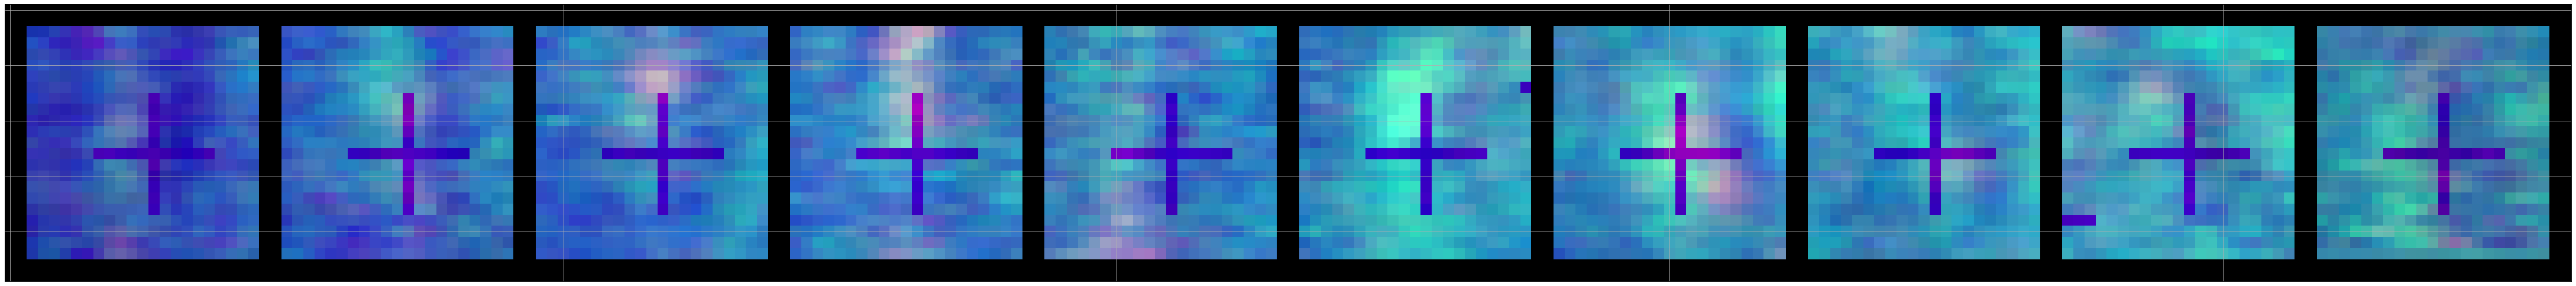

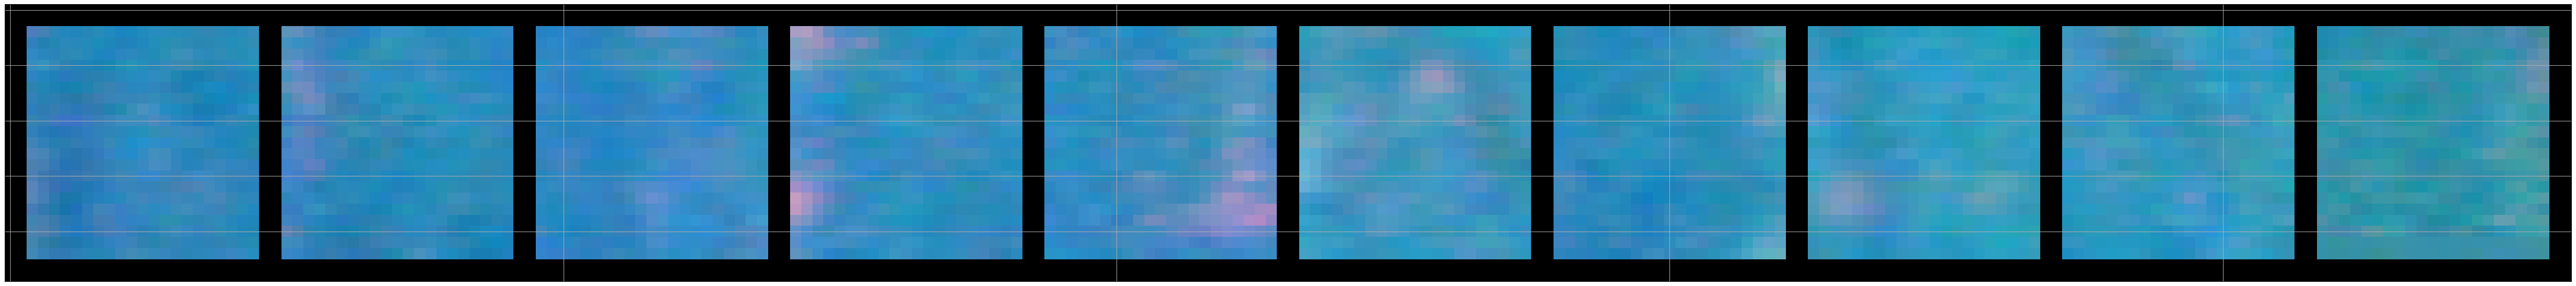

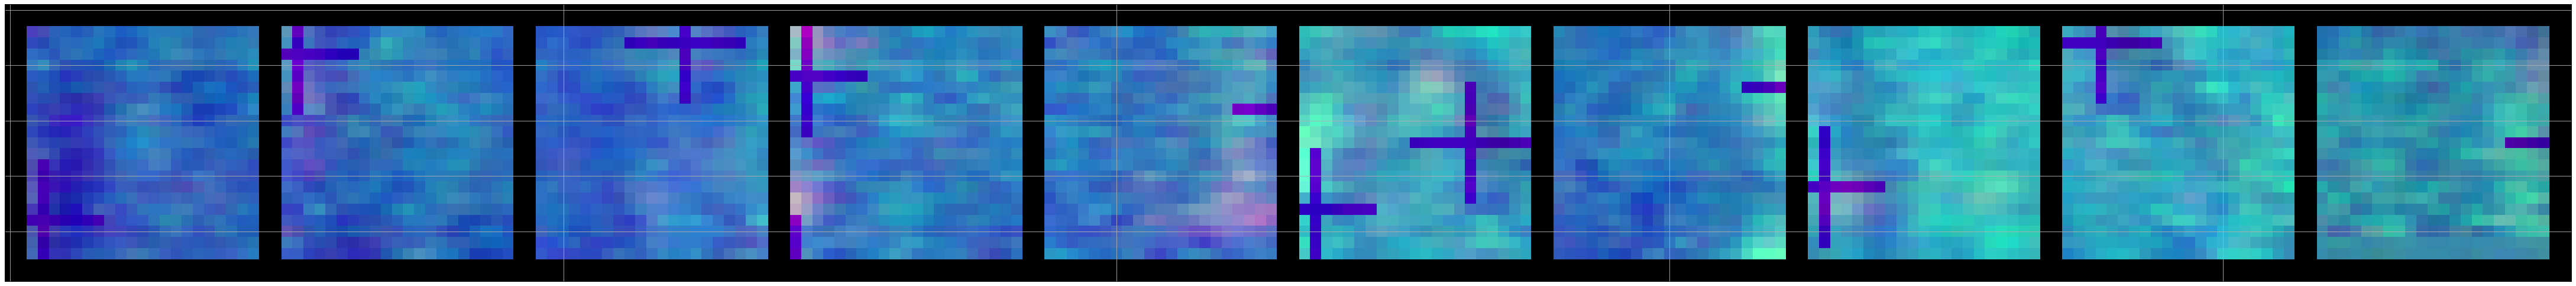

In [41]:
from sharedvariables import get_video_sessions
from patchextraction import SessionPatchExtractor
from plotutils import plot_images_as_grid

video_sessions = get_video_sessions(should_have_marked_cells=True)
vs = video_sessions[0]

patch_extractor = SessionPatchExtractor(vs, patch_size=21)

plot_images_as_grid(patch_extractor.mixed_channel_cell_patches[:10])
plot_images_as_grid(patch_extractor.mixed_channel_marked_cell_patches[:10])

plot_images_as_grid(patch_extractor.mixed_channel_non_cell_patches[:10])
plot_images_as_grid(patch_extractor.mixed_channel_marked_non_cell_patches[:10])

# Create dataset convenience functions

Extract all patches (marked and unmarkded) for all the video session given.

If no video sessions given then all the video sessions automatically created from the videos with cell position csv in the data folder are used.

## Normal patches

  0%|          | 0/8 [00:00<?, ?it/s]

Creating cell and no cell images from videos and cell positions csvs...


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Created 12131 cell patches and 12367 non cell patches


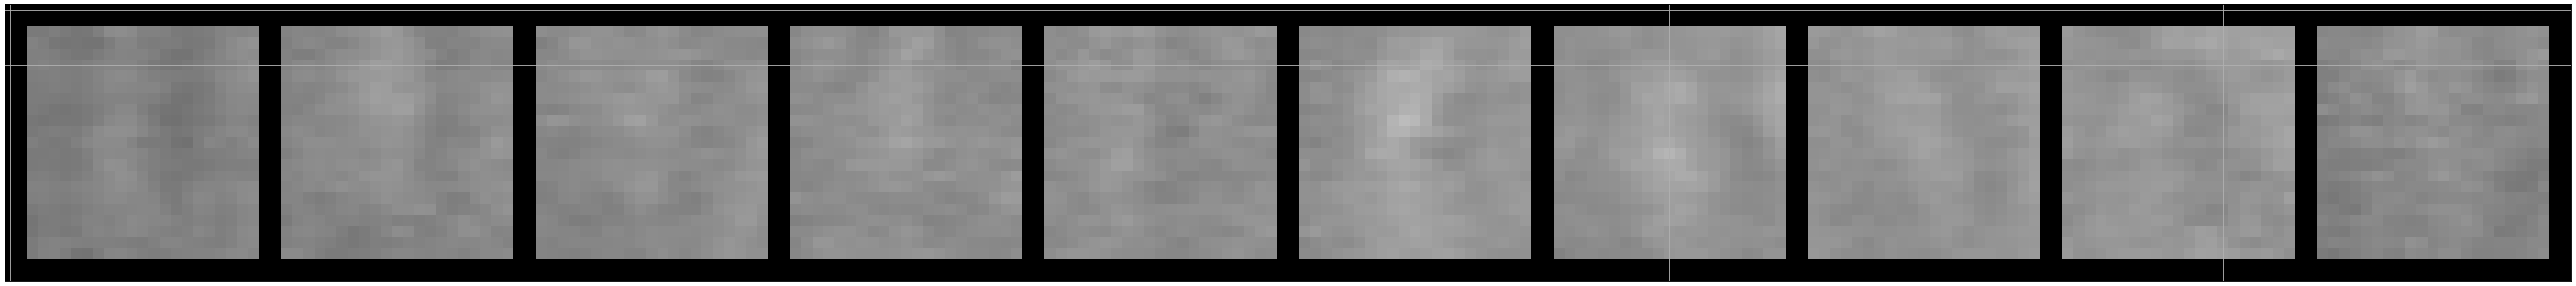

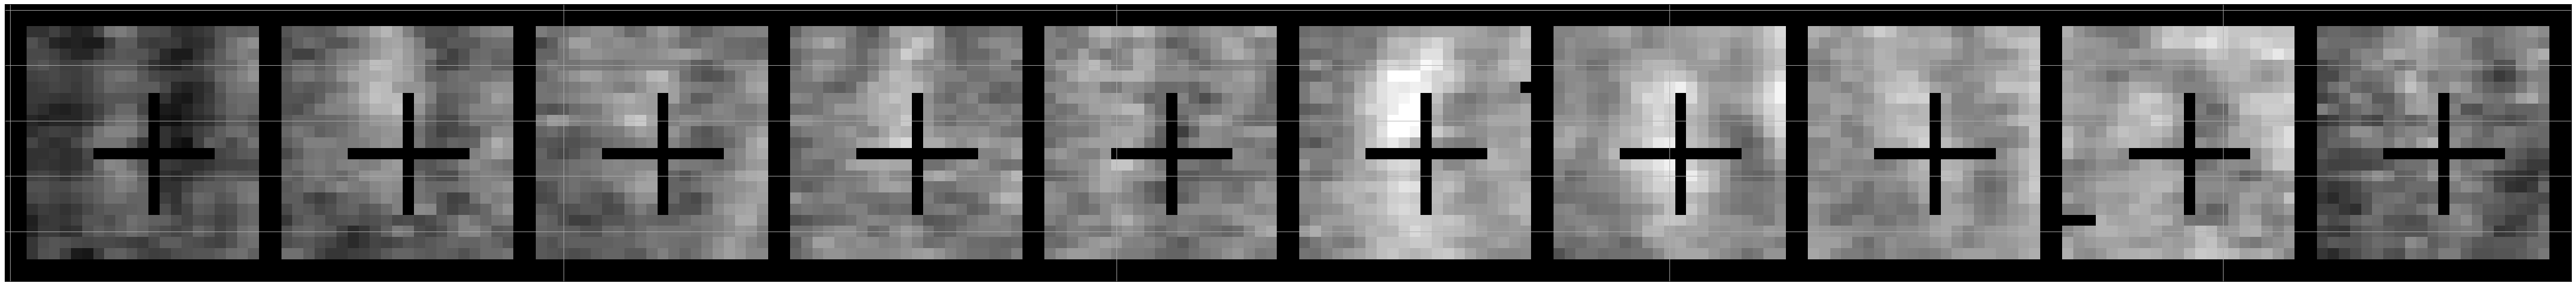

In [46]:
from generate_datasets import create_cell_and_no_cell_patches, create_dataset_from_cell_and_no_cell_images
from imageprosessing import hist_match_images
from sharedvariables import get_video_sessions

reg_video_sessions = get_video_sessions(should_have_marked_cells=True, should_be_registered=True)

cell_images, non_cell_images, cell_images_marked, non_cell_images_marked =\
create_cell_and_no_cell_patches(
    video_sessions=reg_video_sessions,                                                                  
    n_negatives_per_positive=1,                                                                                                
    v=True,
    vv=False
)

plot_images_as_grid(cell_images[:10])
plot_images_as_grid(cell_images_marked[:10])

## Temporal patches

100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


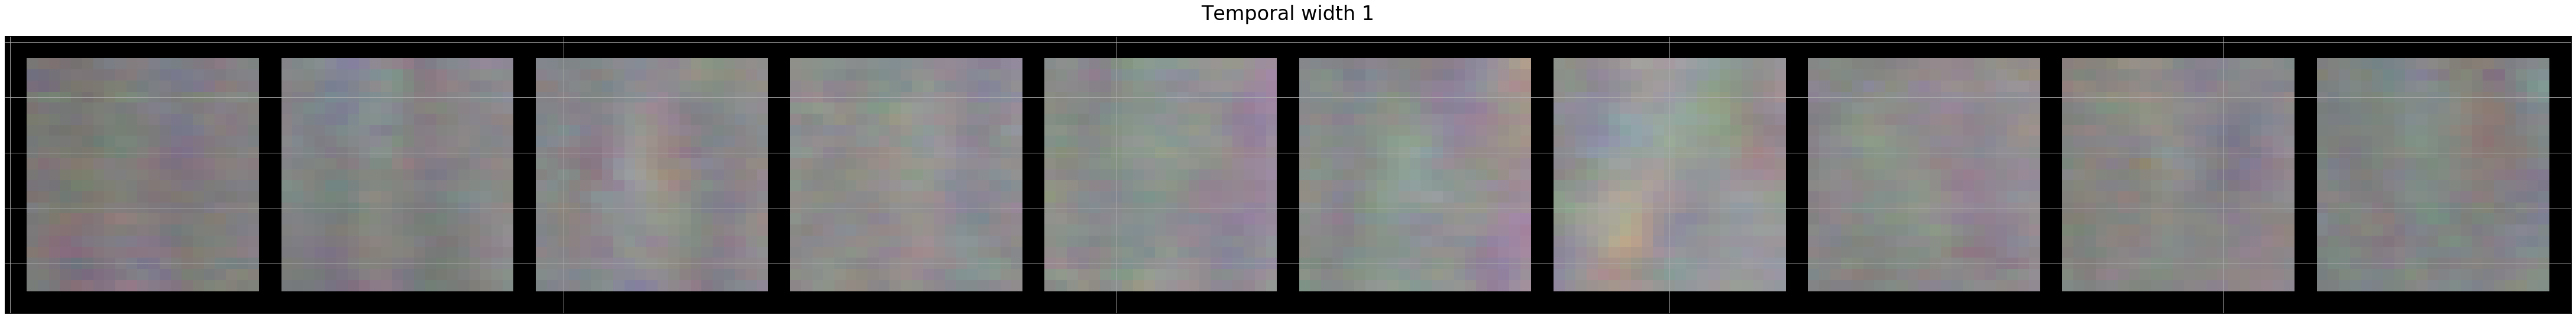

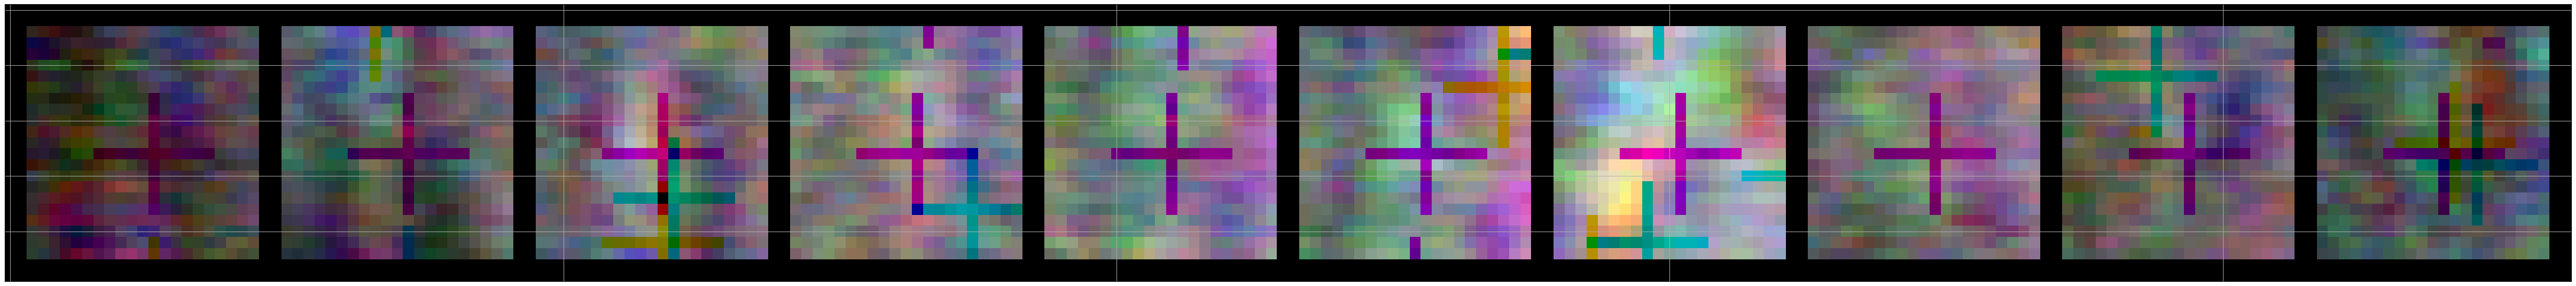

In [48]:
from generate_datasets import create_cell_and_no_cell_patches, create_dataset_from_cell_and_no_cell_images
from imageprosessing import hist_match_images
from sharedvariables import get_video_sessions

reg_video_sessions = get_video_sessions(should_have_marked_cells=True, should_be_registered=True)
cell_images, non_cell_images, cell_images_marked, non_cell_images_marked =\
create_cell_and_no_cell_patches(
    temporal_width=1,
    video_sessions=reg_video_sessions,                                                                                                                                                                
)

plot_images_as_grid(cell_images[:10], title='Temporal width 1')
plot_images_as_grid(cell_images_marked[:10])

## Mixed channel patches

In [4]:
from generate_datasets import create_cell_and_no_cell_patches, create_dataset_from_cell_and_no_cell_images
from imageprosessing import hist_match_images
from sharedvariables import get_video_sessions

reg_video_sessions = get_video_sessions(should_have_marked_cells=True, should_be_registered=True)
cell_images, non_cell_images, cell_images_marked, non_cell_images_marked =\
create_cell_and_no_cell_patches(
    mixed_channel_patches=True,
    video_sessions=reg_video_sessions,                                                                                                                                                                
)

plot_images_as_grid(cell_images[:10], title='Mixed channel patches')
plot_images_as_grid(cell_images_marked[:10])

  0%|                                                                                                                                                                                      | 0/8 [00:02<?, ?it/s]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 3, the array at index 0 has size 2 and the array at index 1 has size 3

In [ ]:
cell_images.shape

In [ ]:
import collections
import torch
from cnnlearning import CNN, train, TrainingTracker 

standardize_dataset = True
trainset, validset = create_dataset_from_cell_and_no_cell_images(cell_images, 
                                                                 non_cell_images,
                                                                 validset_ratio=0.01,
                                                                 standardize=standardize_dataset)
model = CNN(dataset_sample=trainset, output_classes=2).to('cuda')
train_params = collections.OrderedDict(
    optimizer=torch.optim.Adam(model.parameters(), lr=.001, weight_decay=5e-4),
    batch_size=1024 * 7,
    do_early_stop=True,  # Optional default True
    early_stop_patience=40,
    learning_rate_scheduler_patience=20,
    epochs=4000,
    shuffle=True,
    # valid_untrunsformed_normals = valid_untrunsformed_normals,
    evaluation_epochs=5,
    trainset=trainset,
    validset=validset,
)
results: TrainingTracker = train(model,
                                 train_params,
                                 criterion=torch.nn.CrossEntropyLoss(),
                                 device='cuda')

In [ ]:
from classificationutils import classify_labeled_dataset, classify_images

model = results.recorded_model
model.eval()

_, train_accuracy = classify_labeled_dataset(trainset, model)
_, valid_accuracy = classify_labeled_dataset(validset, model)
positive_accuracy = classify_images(cell_images, model, standardize_dataset=standardize_dataset).sum().item() / len(cell_images)
negative_accuracy = (1 - classify_images(non_cell_images, model, standardize_dataset=standardize_dataset)).sum().item() / len(non_cell_images)

print()
print(f'Model trained on {len(cell_images)} cell patches and {len(non_cell_images)} non cell patches.')
print()
print('Brief evaluation - best validation accuracy model')
print('----------------')
print(f'Epoch:\t', results.recorded_model_epoch)
print('Training accuracy:\t', f'{train_accuracy:.3f}')
print('Validation accuracy:\t', f'{valid_accuracy:.3f}')
print()
print('Positive accuracy:\t', f'{positive_accuracy:.3f}')
print('Negative accuracy:\t', f'{negative_accuracy:.3f}')

train_model = results.recorded_train_model
train_model.eval()

_, train_accuracy = classify_labeled_dataset(trainset, train_model)
_, valid_accuracy = classify_labeled_dataset(validset, train_model)
positive_accuracy = classify_images(cell_images, train_model, standardize_dataset=standardize_dataset).sum().item() / len(cell_images)
negative_accuracy = (1 - classify_images(non_cell_images, train_model, standardize_dataset=standardize_dataset)).sum().item() / len(non_cell_images)

print()
print('Brief evaluation - best training accuracy model')
print('----------------')
print(f'Epoch:\t', results.recorded_train_model_epoch)
print('Training accuracy:\t', f'{train_accuracy:.3f}')
print('Validation accuracy:\t', f'{valid_accuracy:.3f}')
print()
print('Positive accuracy:\t', f'{positive_accuracy:.3f}')
print('Negative accuracy:\t', f'{negative_accuracy:.3f}')


### Mixed channel patches

In [ ]:
get_video_sessions(should_have_marked_cells=True, should_be_registered=True)[1]

In [ ]:
from generate_datasets import create_cell_and_no_cell_patches, create_dataset_from_cell_and_no_cell_images
from imageprosessing import hist_match_images
from sharedvariables import get_video_sessions

reg_video_sessions = get_video_sessions(should_have_marked_cells=True, should_be_registered=True)
cell_images, non_cell_images, cell_images_marked, non_cell_images_marked = create_cell_and_no_cell_patches(
    video_sessions=reg_video_sessions,
    mixed_channel_patches=True,
    normalize=False,                                                                             
    n_negatives_per_positive=1,                                                                                                
    v=True,
    vv=False
)
print(f'Cell patches: {cell_images.shape}. Non cell patches {non_cell_images.shape}.')

In [ ]:
from plotutils import plot_images_as_grid
plot_images_as_grid(cell_images[..., 0], title='cell patches oa790 channel')
plot_images_as_grid(cell_images[..., 1], title='cell paches oa850 channel')
plot_images_as_grid(cell_images_marked[..., 0], title='cell patches oa790 channel  (marked for debugging)')

plot_images_as_grid(non_cell_images[..., 0], title='non cell patches a790 channel')
plot_images_as_grid(non_cell_images[..., 1], title='non cell patches oa850 channel')
plot_images_as_grid(non_cell_images_marked[..., 0], title='non cell patches oa790 channel  (marked for debugging)')

In [ ]:
import collections
import torch
from cnnlearning import CNN, train, TrainingTracker 

standardize_dataset = True
trainset, validset = create_dataset_from_cell_and_no_cell_images(cell_images, 
                                                                 non_cell_images,
                                                                 validset_ratio=0.01,
                                                                 standardize=standardize_dataset)
model = CNN(dataset_sample=trainset, output_classes=2).to('cuda')
train_params = collections.OrderedDict(
    optimizer=torch.optim.Adam(model.parameters(), lr=.001, weight_decay=5e-4),
    batch_size=1024 * 7,
    do_early_stop=True,  # Optional default True
    early_stop_patience=40,
    learning_rate_scheduler_patience=20,
    epochs=4000,
    shuffle=True,
    # valid_untrunsformed_normals = valid_untrunsformed_normals,
    evaluation_epochs=5,
    trainset=trainset,
    validset=validset,
)
results: TrainingTracker = train(model,
                                 train_params,
                                 criterion=torch.nn.CrossEntropyLoss(),
                                 device='cuda')

In [ ]:
from plotutils import plot_images_as_grid
from generate_datasets import create_cell_and_no_cell_patches, create_dataset_from_cell_and_no_cell_images
from imageprosessing import hist_match_images
from sharedvariables import get_video_sessions
from imageprosessing import SessionPreprocessor, enhance_motion_contrast

reg_video_sessions = get_video_sessions(should_have_marked_cells=True, should_be_registered=True)

for vs in reg_video_sessions:
    pr = SessionPreprocessor(vs, [
        enhance_motion_contrast
    ])
    pr.apply_preprocessing()
    
cell_images_reg, non_cell_images_reg, _, _ = create_cell_and_no_cell_patches(
    video_sessions=reg_video_sessions,
    normalize=False,                                                                             
    n_negatives_per_positive=1,                                                                                                
    v=True,
    vv=False
)

In [ ]:
from plotutils import plot_images_as_grid
plot_images_as_grid(cell_images_reg)
plot_images_as_grid(non_cell_images_reg)

In [ ]:
import collections
import torch
from cnnlearning import CNN, train, TrainingTracker 

trainset, validset = create_dataset_from_cell_and_no_cell_images(cell_images, non_cell_images, standardize=True)
model = CNN(dataset_sample=trainset, output_classes=2).to('cuda')
train_params = collections.OrderedDict(
    optimizer=torch.optim.Adam(model.parameters(), lr=.001, weight_decay=5e-4),
    batch_size=1024 * 7,
    do_early_stop=True,  # Optional default True
    early_stop_patience=80,
    learning_rate_scheduler_patience=100,
    epochs=700,
    shuffle=True,
    # valid_untrunsformed_normals = valid_untrunsformed_normals,
    evaluation_epochs=50,
    trainset=trainset,
    validset=validset,
)
results: TrainingTracker = train(model,
                                 train_params,
                                 criterion=torch.nn.CrossEntropyLoss(),
                                 device='cuda')

In [ ]:
from classificationutils import classify_labeled_dataset, classify_images

model = results.recorded_model
model.eval()

_, train_accuracy = classify_labeled_dataset(trainset, model)
_, valid_accuracy = classify_labeled_dataset(validset, model)
positive_accuracy = classify_images(cell_images, model, standardize_dataset=standardize_dataset).sum().item() / len(cell_images)
negative_accuracy = (1 - classify_images(non_cell_images, model, standardize_dataset=standardize_dataset)).sum().item() / len(non_cell_images)

print()
print(f'Model trained on {len(cell_images)} cell patches and {len(non_cell_images)} non cell patches.')
print()
print('Brief evaluation - best validation accuracy model')
print('----------------')
print(f'Epoch:\t', results.recorded_model_epoch)
print('Training accuracy:\t', f'{train_accuracy:.3f}')
print('Validation accuracy:\t', f'{valid_accuracy:.3f}')
print()
print('Positive accuracy:\t', f'{positive_accuracy:.3f}')
print('Negative accuracy:\t', f'{negative_accuracy:.3f}')

train_model = results.recorded_train_model
train_model.eval()

_, train_accuracy = classify_labeled_dataset(trainset, train_model)
_, valid_accuracy = classify_labeled_dataset(validset, train_model)
positive_accuracy = classify_images(cell_images, train_model, standardize_dataset=standardize_dataset).sum().item() / len(cell_images)
negative_accuracy = (1 - classify_images(non_cell_images, train_model, standardize_dataset=standardize_dataset)).sum().item() / len(non_cell_images)

print()
print('Brief evaluation - best training accuracy model')
print('----------------')
print(f'Epoch:\t', results.recorded_train_model_epoch)
print('Training accuracy:\t', f'{train_accuracy:.3f}')
print('Validation accuracy:\t', f'{valid_accuracy:.3f}')
print()
print('Positive accuracy:\t', f'{positive_accuracy:.3f}')
print('Negative accuracy:\t', f'{negative_accuracy:.3f}')

In [ ]:
from generate_datasets import get_cell_and_no_cell_patches

trainset, validset, cell_images, non_cell_images, cell_images_marked, non_cell_images_marked, _ =\
get_cell_and_no_cell_patches(apply_data_augmentation_to_dataset=True, try_load_from_cache=False)

In [ ]:
import torch.utils.data
import matplotlib.pyplot as plt
loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)
for image, label in trainset:
    print(image.shape)
    plt.imshow(image.squeeze())
    break

### Applying preprocessing to session frames

In [ ]:
from sharedvariables import get_video_sessions
from imageprosessing import SessionPreprocessor, enhance_motion_contrast

video_sessions = get_video_sessions(should_have_marked_video=True)
vs = video_sessions[0]


preprocessor = SessionPreprocessor(vs, lambda frames: enhance_motion_contrast(frames, sigma=1.2))

plt.subplot(121)
plt.imshow(vs.frames_oa790[0])
plt.title('Before applying preprocessing', fontsize=15)

preprocessor.apply_preprocessing()

plt.subplot(122)
plt.imshow(vs.frames_oa790[0])
plt.title('After applying preprocessing', fontsize=15)
pass

In [ ]:
from sharedvariables import get_video_sessions
from imageprosessing import SessionPreprocessor, enhance_motion_contrast, normalize_data, frame_differencing
import matplotlib.pyplot as plt
import numpy as np

video_sessions = get_video_sessions(should_have_marked_video=True)
vs = video_sessions[0]


preprocessor = SessionPreprocessor(vs, [
    lambda frames: frame_differencing(frames, sigma=1.2),
    lambda frames: np.uint8(normalize_data(frames, (0, 255))),
    lambda frames: enhance_motion_contrast(frames, sigma=1.2)]
                                  )

plt.subplot(121)
plt.imshow(vs.frames_oa790[0])
plt.title('Before applying preprocessing', fontsize=15)

preprocessor.apply_preprocessing_to_oa790()

plt.subplot(122)
plt.imshow(vs.frames_oa790[0])
plt.title('After applying preprocessing', fontsize=15)
pass

In [ ]:
video_sessions = get_video_sessions(should_have_marked_video=True)
vs = video_sessions[0]
plt.imshow(filters.gaussian(vs.masked_frames_oa790[0]))

In [ ]:
blur_images(vs.masked_frames_oa790).max()

In [ ]:
from sharedvariables import get_video_sessions
from imageprosessing import SessionPreprocessor, equalize_adapthist_images
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters

video_sessions = get_video_sessions(should_have_marked_video=True)
vs = video_sessions[0]

def blur_images(frames, sigma=1):
    blurred_images = np.empty_like(frames, dtype=np.float64)
    for i, im in enumerate(frames):
        blurred_images[i] = filters.gaussian(im, sigma)
    return blurred_images

preprocessor = SessionPreprocessor(vs, [
    lambda frames: blur_images(frames, sigma=2),
    lambda frames: np.uint8(frames * 255),
    equalize_adapthist_images,
    lambda frames: np.ma.array([filters.unsharp_mask(f, radius=5, amount=1, preserve_range=True) for f in frames], dtype=np.uint8),
])

_, axes = plt.subplots(1, 2, figsize=(60, 70))
axes[0].imshow(vs.frames_oa790[0], cmap='gray')
axes[0].set_title('Before applying preprocessing', fontsize=15)

preprocessor.apply_preprocessing_to_oa790()

axes[1].imshow(vs.frames_oa790[0], cmap='gray')
axes[1].set_title('After applying preprocessing', fontsize=15)
pass

In [ ]:
for f in [
    lambda frames: frame_differencing(frames, sigma=1.2),
    lambda frames: enhance_motion_contrast(frames, sigma=1.2),
                                       ]:
    print(f)

In [ ]:
from sharedvariables import get_video_sessions
from imageprosessing import SessionPreprocessor, enhance_motion_contrast
import mahotas as mh
video_sessions = get_video_sessions(should_have_marked_video=True)
vs = video_sessions[0]

plt.imshow(mh.gaussian_filter(vs.masked_frames_oa790.mean(0), sigma=2))
# preprocessor = SessionPreprocessor(vs, lambda frames, masks: np.ma.mean(frames, masks))

# plt.subplot(121)
# plt.imshow(vs.frames_oa790[0])
# plt.title('Before applying preprocessing', fontsize=15)

# preprocessor.apply_preprocessing()

# plt.subplot(122)
# plt.imshow(vs.frames_oa790[0])
# plt.title('After applyging preprocessing', fontsize=15)
# pass

In [ ]:
string = 'hey'
import collections
print(isinstance(string, List))
for s in string:
    print(s)

In [ ]:
string = 'Hey'
list(string)

In [ ]:
plt.imshow(frame_differencing(vs.masked_frames_oa790, 2)[3])
frame_differencing(vs.masked_frames_oa790, 2).max()

In [ ]:
video_sessions = get_video_sessions()

vs = [vs for vs in video_sessions if 'shared-videos' in vs.video_file][0]
print(vs)
plt.imshow(vs.frames_oa790[0])
plt.show()
extractor = SessionPatchExtractor(vs, patch_size=21)
preprocessor = SessionPreprocessor(vs, lambda frames, masks: enhance_motion_contrast(frames, masks, sigma=0.125, mask_crop_pixels=0))
preprocessor.apply_preprocessing_to_oa790()
plt.imshow(vs.frames_oa790[0])

In [ ]:
plt.imshow(vs.frames_oa790[23])

In [ ]:
from sharedvariables import get_video_sessions
from imageprosessing import SessionPreprocessor, enhance_motion_contrast
from patchextraction import SessionPatchExtractor

video_sessions = get_video_sessions(should_have_marked_video=True)
vs = video_sessions[0]

extractor = SessionPatchExtractor(vs, patch_size=21)
preprocessor = SessionPreprocessor(vs, lambda frames, masks: enhance_motion_contrast(frames, masks, sigma=1.2, mask_crop_pixels=0))

cell_patches_before_preprocessing = extractor.cell_patches_oa790
non_cell_patches_before_preprocessing = extractor.non_cell_patches_oa790

plt.subplot(121)
plt.imshow(vs.frames_oa790[0])
plt.title('Before applying preprocessing', fontsize=15)
plt.scatter(vs.cell_positions[0][:, 0], vs.cell_positions[0][:, 1])

preprocessor.apply_preprocessing()

extractor._reset_patches()
cell_patches_after_preprocessing = extractor.cell_patches_oa790
non_cell_patches_after_preprocessing = extractor.non_cell_patches_oa790

plt.subplot(122)
plt.imshow(vs.frames_oa790[0])
plt.title('After applying preprocessing', fontsize=15)
pass

In [ ]:
plot_images_as_grid(cell_patches_before_preprocessing[:10])
plot_images_as_grid(non_cell_patches_before_preprocessing[:10])

plot_images_as_grid(cell_patches_after_preprocessing[:10])
plot_images_as_grid(non_cell_patches_after_preprocessing[:10])

In [ ]:
print('Channel oa850')
plot_images_as_grid(patch_extractor.mixed_channel_cell_patches[:10][..., 1])
# plot_images_as_grid(patch_extractor.mixed_channel_marked_cell_patches[:10][..., 1])

plot_images_as_grid(patch_extractor.mixed_channel_non_cell_patches[:10][..., 1])
# plot_images_as_grid(patch_extractor.mixed_channel_marked_non_cell_patches[:10][..., 1])

In [ ]:
 patch_extractor.temporal_marked_cell_patches_oa790[1].transpose(2, 0, 1).shape

In [ ]:
from sharedvariables import get_video_sessions
from patchextraction import SessionPatchExtractor
from plotutils import plot_images_as_grid, no_ticks
import numpy as np

video_sessions = get_video_sessions(should_have_marked_video=True)
vs = video_sessions[0]

patch_extractor = SessionPatchExtractor(vs, patch_size=37)
patch_extractor.patch_size =31
print(patch_extractor.temporal_cell_patches_oa790.max())
print(patch_extractor.temporal_marked_cell_patches_oa790.max())

_, axes = plt.subplots(1, 3)
no_ticks(axes)
for ax, channel_patch in zip(axes, patch_extractor.temporal_marked_cell_patches_oa790[29].transpose(2, 0, 1)):
    ax.imshow(channel_patch, cmap='gray')
    
# _, axes = plt.subplots(1, 3)
# no_ticks(axes)
# for ax, channel_patch in zip(axes, patch_extractor.temporal_non_cell_patches_oa790[0].transpose(2, 0, 1)):
#     ax.imshow(channel_patch, cmap='gray')

In [ ]:
 patch_extractor.temporal_non_cell_patches_oa790

In [ ]:
patch_extractor.temporal_marked_cell_patches_oa790[1].transpose(2, 0, 1).shape

In [ ]:
# To get all the patches extracted
plot_images_as_grid(patch_extractor.cell_patches_oa790)
plot_images_as_grid(patch_extractor.marked_cell_patches_oa790)

plot_images_as_grid(patch_extractor.non_cell_patches_oa790)
plot_images_as_grid(patch_extractor.marked_non_cell_patches_oa790)

### How to get standard deviation image and vessel masks

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(40, 10))

# If empty string then file not found
if session.std_image_oa850_file != "":
    axes[0].imshow(session.std_image_oa850)
    axes[0].set_title('Std image oa850', fontsize=20)

if session.std_image_confocal_file != "":
    axes[1].imshow(session.std_image_confocal)
    axes[1].set_title('Std image confocal', fontsize=20)

if session.vessel_mask_oa850_file != '':
    axes[2].imshow(session.vessel_mask_oa850)
    axes[2].set_title('Vessel mask oa850', fontsize=20)

if session.vessel_mask_confocal_file != '':
    axes[3].imshow(session.vessel_mask_confocal)
    axes[3].set_title('Vessel mask confocal', fontsize=20)
pass